<a href="https://colab.research.google.com/github/Doctorjung/web1/blob/main/lotto_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 소개

1회차부터 최근까지 로또 당첨번호를 수집하고, 딥러닝 알고리즘 LSTM 기법으로 그 다음 번호를 예측한다.

# 목차

1. 데이터 수집
2. 데이터 전처리
3. 모델 구성 및 학습
4. 모델 평가








# 1. 데이터 수집

동행복권 홈페이지 : https://dhlottery.co.kr 에서 1회차부터 1004회차까지 당첨번호를 엑셀 파일로 다운로드 받은 후, scv 파일로 변환합니다.

# 2. 데이터 전처리

In [ ]:
import numpy as np

rows = np.loadtxt("./lotto.csv", delimiter=",")
row_count = len(rows)
print(row_count)

1004


In [ ]:
# 당첨번호를 원핫인코딩벡터(ohbin)으로 변환
def numbers_ohe(numbers):

    ohe = np.zeros(45) #45개의 빈 칸을 만듬

    for i in range(6): #여섯개의 당첨번호에 대해서 반복함
        ohe[int(numbers[i])-1] = 1 #로또번호가 1부터 시작하지만 벡터의 인덱스 시작은 0부터 시작하므로 1을 뺌
    
    return ohe

# 원핫인코딩벡터(ohbin)를 번호로 변환
def ohe_numbers(ohe):

    numbers = []
    
    for i in range(len(ohe)):
        if ohe[i] == 1.0: # 1.0으로 설정되어 있으면 해당 번호를 반환값에 추가한다.
            numbers.append(i+1)
    
    return numbers

In [ ]:
numbers = rows[:, 1:7]
ohes = list(map(numbers_ohe, numbers))

x_samples = ohes[0:row_count-1]
y_samples = ohes[1:row_count]

# 원핫인코딩으로 출력
print(("ohes"))
print("X[0] : " + str(x_samples[0]))
print("Y[0] : " + str(y_samples[0]))

# 번호로 출력
print("numbers")
print("X[0] : " + str(ohe_numbers(x_samples[0])))
print("Y[0] : " + str(ohe_numbers(y_samples[0])))

ohes
X[0] : [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.]
Y[0] : [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
numbers
X[0] : [10, 23, 29, 33, 37, 40]
Y[0] : [9, 13, 21, 25, 32, 42]


# 3. 모델 구성 및 학습

In [ ]:
# 데이터셋 구성 - 훈련셋, 검증셋, 시험셋으로 분리
train_idx = (0, 800)   # 훈련셋 800회

val_idx = (801, 950)   # 검증셋 150회

test_idx = (951, len(x_samples))   # 시험셋 53회

print("train: {0}, val: {1}, test: {2}".format(train_idx, val_idx, test_idx))

train: (0, 800), val: (801, 950), test: (951, 1003)


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models

# LSTM 모델을 생성
model = keras.Sequential([
    keras.layers.LSTM(128, batch_input_shape=(1, 1, 45), return_sequences=False, stateful=True),
    keras.layers.Dense(45, activation='sigmoid')
])

# 모델 컴파일
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# 매 에포크마다 훈련과 검증의 손실 및 정확도를 기록하기 위한 변수
train_loss = []
train_acc = []
val_loss = []
val_acc = []

# 에포크 최대 100회 수행
for epoch in range(100):

    model.reset_states()   # 매 에포크마다 1회부터 다시 훈련하므로 상태 초기화 필요

    batch_train_loss = []
    batch_train_acc = []
    
    for i in range(train_idx[0], train_idx[1]):
        
        xs = x_samples[i].reshape(1, 1, 45)
        ys = y_samples[i].reshape(1, 45)
        
        loss, acc = model.train_on_batch(xs, ys)  # 배치만큼 모델에 학습

        batch_train_loss.append(loss)
        batch_train_acc.append(acc)

    train_loss.append(np.mean(batch_train_loss))
    train_acc.append(np.mean(batch_train_acc))

    batch_val_loss = []
    batch_val_acc = []

    for i in range(val_idx[0], val_idx[1]):

        xs = x_samples[i].reshape(1, 1, 45)
        ys = y_samples[i].reshape(1, 45)
        
        loss, acc = model.test_on_batch(xs, ys)  # 배치만큼 모델에 입력하여 나온 답을 정답과 비교함
        
        batch_val_loss.append(loss)
        batch_val_acc.append(acc)

    val_loss.append(np.mean(batch_val_loss))
    val_acc.append(np.mean(batch_val_acc))

    print('epoch: {0:4d}, train acc: {1:0.3f}, loss: {2:0.3f}, val acc: {3:0.3f}, loss: {4:0.3f}'.format(epoch, np.mean(batch_train_acc), np.mean(batch_train_loss), np.mean(batch_val_acc), np.mean(batch_val_loss)))

epoch:    0, train acc: 0.018, loss: 0.409, val acc: 0.040, loss: 0.399
epoch:    1, train acc: 0.024, loss: 0.396, val acc: 0.040, loss: 0.398
epoch:    2, train acc: 0.021, loss: 0.394, val acc: 0.034, loss: 0.397
epoch:    3, train acc: 0.021, loss: 0.392, val acc: 0.027, loss: 0.398
epoch:    4, train acc: 0.021, loss: 0.389, val acc: 0.040, loss: 0.400
epoch:    5, train acc: 0.025, loss: 0.384, val acc: 0.027, loss: 0.403
epoch:    6, train acc: 0.026, loss: 0.379, val acc: 0.027, loss: 0.407
epoch:    7, train acc: 0.030, loss: 0.373, val acc: 0.027, loss: 0.411
epoch:    8, train acc: 0.043, loss: 0.366, val acc: 0.027, loss: 0.414
epoch:    9, train acc: 0.044, loss: 0.360, val acc: 0.034, loss: 0.419
epoch:   10, train acc: 0.050, loss: 0.353, val acc: 0.027, loss: 0.423
epoch:   11, train acc: 0.068, loss: 0.345, val acc: 0.034, loss: 0.428
epoch:   12, train acc: 0.066, loss: 0.338, val acc: 0.027, loss: 0.433
epoch:   13, train acc: 0.071, loss: 0.330, val acc: 0.020, loss

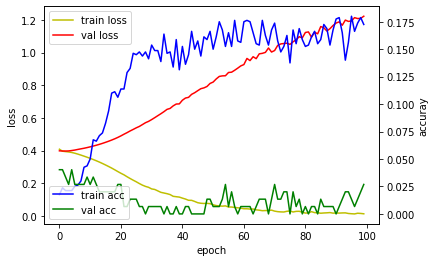

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(train_loss, 'y', label='train loss')
loss_ax.plot(val_loss, 'r', label='val loss')

acc_ax.plot(train_acc, 'b', label='train acc')
acc_ax.plot(val_acc, 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

예측한 번호로 상금을 얼마나 받을 수 있는지 평균값 구하기

In [ ]:
# 100회차부터 최근 회차까지 1~5등 상금의 평균을 낸다.
mean_reward = [ np.mean(rows[99:, 8]),
              np.mean(rows[99:, 9]),
              np.mean(rows[99:, 10]),
              np.mean(rows[99:, 11]),
              np.mean(rows[99:, 12])]

print(mean_reward)

[2432394622.9392266, 57178357.17016575, 1448903.6, 52584.17679558011, 5000.0]


# 모델 평가

In [ ]:
# 등수와 상금을 반환
# 순위에 오르지 못한 경우에는 등수가 0으로 반환
def calc_reward(true_numbers, true_bonus, pred_numbers):

    count = 0

    for ps in pred_numbers:
        if ps in true_numbers:
            count += 1

    if count == 6:
        return 0, mean_reward[0]
    elif count == 5 and true_bonus in pred_numbers:
        return 1, mean_reward[1]
    elif count == 5:
        return 2, mean_reward[2]
    elif count == 4:
        return 3, mean_reward[3]
    elif count == 3:
        return 4, mean_reward[4]

    return 5, 0

In [ ]:
def gen_numbers_from_probability(nums_prob):

    ball_box = []

    for n in range(45):
        ball_count = int(nums_prob[n] * 100 + 1)
        ball = np.full((ball_count), n+1)   # 1부터 시작
        ball_box += list(ball)

    selected_balls = []

    while True:
        
        if len(selected_balls) == 6:
            break
        
        ball_index = np.random.randint(len(ball_box), size=1)[0]
        ball = ball_box[ball_index]

        if ball not in selected_balls:
            selected_balls.append(ball)

    return selected_balls

In [ ]:
train_total_reward = []
train_total_grade = np.zeros(6, dtype=int)

val_total_reward = []
val_total_grade = np.zeros(6, dtype=int)

test_total_reward = []
test_total_grade = np.zeros(6, dtype=int)

model.reset_states()

print('[No. ] 1등 2등 3등 4등 5등 6등 Rewards')

for i in range(len(x_samples)):
    xs = x_samples[i].reshape(1, 1, 45)
    ys_pred = model.predict_on_batch(xs)   # 모델의 출력값을 얻음
    
    sum_reward = 0
    sum_grade = np.zeros(6, dtype=int)   # 6등까지 변수

    for n in range(10):   # 10번 수행
        numbers = gen_numbers_from_probability(ys_pred[0])
        
        # i회차 입력 후 나온 출력을 i+1회차와 비교
        grade, reward = calc_reward(rows[i+1,1:7], rows[i+1,7], numbers) 
        
        sum_reward += reward
        sum_grade[grade] += 1

        if i >= train_idx[0] and i < train_idx[1]:
            train_total_grade[grade] += 1
        elif i >= val_idx[0] and i < val_idx[1]:
            val_total_grade[grade] += 1
        elif i >= test_idx[0] and i < test_idx[1]:
            val_total_grade[grade] += 1
    
    if i >= train_idx[0] and i < train_idx[1]:
        train_total_reward.append(sum_reward)
    elif i >= val_idx[0] and i < val_idx[1]:
        val_total_reward.append(sum_reward)
    elif i >= test_idx[0] and i < test_idx[1]:
        test_total_reward.append(sum_reward)
                        
    print('[{0:4d}] {1:3d} {2:3d} {3:3d} {4:3d} {5:3d} {6:3d} {7:15,d}'.format(i+1, sum_grade[0], sum_grade[1], sum_grade[2], sum_grade[3], sum_grade[4], sum_grade[5], int(sum_reward)))

print('Total') 
print('==============================')    
print('Train {0:5d} {1:5d} {2:5d} {3:5d} {4:5d} {5:5d} {6:15,d}'.format(train_total_grade[0], train_total_grade[1], train_total_grade[2], train_total_grade[3], train_total_grade[4], train_total_grade[5], int(sum(train_total_reward))))
print('Val   {0:5d} {1:5d} {2:5d} {3:5d} {4:5d} {5:5d} {6:15,d}'.format(val_total_grade[0], val_total_grade[1], val_total_grade[2], val_total_grade[3], val_total_grade[4], val_total_grade[5], int(sum(val_total_reward))))
print('Test  {0:5d} {1:5d} {2:5d} {3:5d} {4:5d} {5:5d} {6:15,d}'.format(test_total_grade[0], test_total_grade[1], test_total_grade[2], test_total_grade[3], test_total_grade[4], test_total_grade[5], int(sum(test_total_reward))))
print('==============================')    

[No. ] 1등 2등 3등 4등 5등 6등 Rewards
[   1]   3   0   5   2   0   0   7,304,533,555
[   2]   3   0   5   2   0   0   7,304,533,555
[   3]   2   0   4   4   0   0   4,870,795,196
[   4]   2   0   7   1   0   0   4,874,984,155
[   5]   6   0   3   1   0   0  14,598,767,032
[   6]   4   0   6   0   0   0   9,738,271,913
[   7]   4   0   4   2   0   0   9,735,479,274
[   8]   4   0   6   0   0   0   9,738,271,913
[   9]   3   0   6   1   0   0   7,305,929,874
[  10]   3   0   6   1   0   0   7,305,929,874
[  11]   2   0   8   0   0   0   4,876,380,474
[  12]   2   0   6   2   0   0   4,873,587,835
[  13]   4   3   3   0   0   0   9,905,460,274
[  14]   2   0   5   2   1   0   4,872,143,932
[  15]   5   0   4   1   0   0  12,167,821,313
[  16]   3   0   5   2   0   0   7,304,533,555
[  17]   7   0   1   2   0   0  17,028,316,432
[  18]   6   0   3   1   0   0  14,598,767,032
[  19]   5   1   2   2   0   0  12,222,154,447
[  20]   5   0   4   1   0   0  12,167,821,313
[  21]   1   0   9   0   0 

In [ ]:
# 에포크 최대 100회 수행
for epoch in range(100):

    model.reset_states()  # 매 에포크마다 1회부터 다시 훈련하므로 상태 초기화 필요

    for i in range(len(x_samples)):
        
        xs = x_samples[i].reshape(1, 1, 45)
        ys = y_samples[i].reshape(1, 45)
        
        loss, acc = model.train_on_batch(xs, ys)  # 배치만큼 모델 학습

        batch_train_loss.append(loss)
        batch_train_acc.append(acc)

    train_loss.append(np.mean(batch_train_loss))
    train_acc.append(np.mean(batch_train_acc))

    print('epoch {0:4d} train acc {1:0.3f} loss {2:0.3f}'.format(epoch, np.mean(batch_train_acc), np.mean(batch_train_loss)))  

epoch    0 train acc 0.146 loss 0.129
epoch    1 train acc 0.141 loss 0.168
epoch    2 train acc 0.139 loss 0.170
epoch    3 train acc 0.145 loss 0.163
epoch    4 train acc 0.149 loss 0.155
epoch    5 train acc 0.149 loss 0.148
epoch    6 train acc 0.153 loss 0.141
epoch    7 train acc 0.153 loss 0.136
epoch    8 train acc 0.154 loss 0.130
epoch    9 train acc 0.154 loss 0.125
epoch   10 train acc 0.155 loss 0.120
epoch   11 train acc 0.154 loss 0.117
epoch   12 train acc 0.154 loss 0.113
epoch   13 train acc 0.154 loss 0.109
epoch   14 train acc 0.155 loss 0.106
epoch   15 train acc 0.156 loss 0.103
epoch   16 train acc 0.157 loss 0.100
epoch   17 train acc 0.158 loss 0.097
epoch   18 train acc 0.159 loss 0.095
epoch   19 train acc 0.159 loss 0.092
epoch   20 train acc 0.160 loss 0.090
epoch   21 train acc 0.160 loss 0.088
epoch   22 train acc 0.160 loss 0.086
epoch   23 train acc 0.162 loss 0.084
epoch   24 train acc 0.162 loss 0.082
epoch   25 train acc 0.162 loss 0.080
epoch   26 t

In [ ]:
# 마지막 회차까지 학습한 모델로 다음 회차 번호예측

print('receive numbers')

xs = x_samples[-1].reshape(1, 1, 45)

ys_pred = model.predict_on_batch(xs)

list_numbers = []

for n in range(10):
    numbers = gen_numbers_from_probability(ys_pred[0])
    numbers.sort()
    print('{0} : {1}'.format(n, numbers))
    list_numbers.append(numbers)

receive numbers
0 : [9, 15, 19, 22, 26, 45]
1 : [15, 19, 20, 23, 28, 45]
2 : [1, 15, 19, 34, 37, 45]
3 : [14, 15, 19, 24, 42, 45]
4 : [9, 15, 19, 39, 41, 45]
5 : [14, 19, 35, 39, 42, 45]
6 : [11, 15, 19, 39, 43, 45]
7 : [12, 14, 15, 19, 41, 45]
8 : [2, 15, 19, 36, 43, 45]
9 : [8, 10, 15, 31, 41, 45]
